# ZECS

Classical shadow (CS) has opened the door to predicting the characteristics of quantum systems using very few measurements. As quantum systems grow in size, new ways to characterize them are needed to show the quality of their qubits, gates, and how noise affects them. In this work, we explore the capabilities of CS for reconstructing density state operators of sections of quantum devices to make a diagnostic of their qubits quality. We introduce **zero-entropy classical shadow** (ZECS), a methodology that focuses on reconstructing a positive semidefinite and unit trace density state operator using the CS information. This procedure makes a reliable reconstruction of the density state operator removing partially the errors associated with a limited sampling and quantum device noise. It gives a threshold of the maximum coherent information that qubits on a quantum device have.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Statevector
from scipy.linalg import sqrtm, logm
from collections import defaultdict

zero_state = np.array([[1,0],[0,0]], dtype=complex)
one_state = np.array([[0,0],[0,1]], dtype=complex)
phase_z = np.array([[1,0],[0,-1j]], dtype=complex)
hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]], dtype=complex)
identity = np.eye(2, dtype=complex)
unitaries = [hadamard, hadamard @ phase_z , identity]

In [84]:
backends = {}
backends["qasm_simulator"] = Aer.get_backend("qasm_simulator")
backends["fake_jakarta"] = FakeJakartaV2() # Fake device

In [85]:
def classical_shadows_circuits(circuit, unitary_ids, backend):
    """
    Input:
        circuit: Qiskit circuit that one wants to know the density matrix
        unitary_ids: Random basis to measure the circuit to recover the Classical Shadows information
        backend: Where the circuit will run (Important to transpile in terms of the backend layout) 
    Return: Circuit with the classical shadows basis.
    """
    num_shadow = len(unitary_ids)
    num_qubits = circuit.num_qubits
    qcs = []
    for shadow_i in range(num_shadow):
        qc_g = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            if unitary_ids[shadow_i, i] == 0:
                qc_g.h(i)
            elif unitary_ids[shadow_i, i] == 1:
                qc_g.sdg(i)
                qc_g.h(i) 
            elif unitary_ids[shadow_i, i] == 2:
                pass
            else:
                raise ValueError("This is not a valid pauli string")
        qc_g = transpile(qc_g, backend, optimization_level=0)
        qc = circuit.compose(qc_g, range(num_qubits))
        qc.add_register(ClassicalRegister(num_qubits))
        qc.measure(range(num_qubits), reversed(range(num_qubits)))
        qcs.append(qc)
        if not shadow_i % (num_shadow//10):
            print(f" Shadows: {shadow_i}")
    return qcs

def snapshot_state(b_list, obs_list, list_qubits):
    num_qubits = len(b_list)
    if len(list_qubits) == 0:
        list_qubits = range(num_qubits)
    # computational basis state
    rho_snapshot = [1]
    for i in reversed(list_qubits):
        state = zero_state if b_list[i] == "0" else one_state
        U = unitaries[obs_list[i]] 
        local_rho = 3 * (U.conj().T @ state @ U) - identity # Eq. S44 classical shadows paper
        rho_snapshot = np.kron(rho_snapshot, local_rho)
    return rho_snapshot

def shadow_state_reconstruction(shadow, basis, list_qubits):
    num_snapshots = len(shadow)
    num_qubits = len(list_qubits)
    
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(shadow[i], basis[i], list_qubits)
    
    return shadow_rho / num_snapshots

def zecs(p):
    """
    Find the singular vector corresponding to the smallest singular value 
    (which can approximate the zero energy coherent state, ZEC).

    Parameters:
    p (numpy.ndarray): A density matrix or any square matrix.

    Returns:
    numpy.ndarray: The singular vector corresponding to the smallest singular value.
    """
    
    # Step 1: Perform Singular Value Decomposition (SVD) of the input matrix p.
    # np.linalg.svd returns three matrices: U and singular values (S).
    U, S, _ = np.linalg.svd(p, hermitian=True)
    
    # Step 2: Extract the right-singular vector (fist column of U) corresponding to the largest singular value.
    # This state vector contains the largest overlap with the ideal state vector that described the given circuit.
    best_sv = U[:,0].reshape(-1, 1)  # Reshaping into a column vector.

    # Step 3: Return the singular vector corresponding to the largest singular value.
    return best_sv


def fidelity(rho_ideal, rho_real):
    """
    Calculate the fidelity between two quantum states represented by density matrices.
    
    Fidelity is a measure of how close two quantum states are, where a value of 1 means 
    the states are identical, and a value of 0 means they are orthogonal (completely different).

    Parameters:
    rho_ideal (numpy.ndarray): The ideal density matrix (target quantum state).
    rho_real (numpy.ndarray): The actual density matrix (quantum state to compare to the ideal).

    Returns:
    float: The fidelity between rho_ideal and rho_real, a value between 0 and 1.
    """
    
    # Step 1: Compute the matrix square root of the real density matrix (rho_real)
    # The matrix square root operation finds a matrix such that s_rho_real * s_rho_real = rho_real
    s_rho_real = sqrtm(rho_real)

    # Step 2: Compute the intermediate matrix: s_rho_real * rho_ideal * s_rho_real
    # This is part of the Uhlmann's fidelity formula: sqrt(sqrt(rho_real) * rho_ideal * sqrt(rho_real))
    intermediate_matrix = s_rho_real @ rho_ideal @ s_rho_real

    # Step 3: Take the matrix square root of the intermediate result to continue the fidelity calculation
    # sqrtm computes the square root of the matrix
    sqrt_intermediate_matrix = sqrtm(intermediate_matrix)

    # Step 4: The fidelity is the squared trace of the resulting matrix.
    # .trace() computes the sum of the diagonal elements of the matrix.
    # .real ensures we only take the real part of the trace (since small imaginary values might arise from numerical errors).
    fidelity_value = (sqrt_intermediate_matrix.trace().real) ** 2

    # Step 5: Return the fidelity value (a number between 0 and 1)
    return fidelity_value

def entropy(p):
    """
    Calculate the von Neumann entropy of a density matrix.

    The von Neumann entropy is a measure of the quantum state's uncertainty or mixedness.
    It is given by the formula: S(p) = -Tr(p * log(p)), where 'log' is the matrix logarithm,
    and Tr() is the trace operation (sum of diagonal elements).

    Parameters:
    p (numpy.ndarray): The density matrix, a square matrix that represents the quantum state.

    Returns:
    float: The von Neumann entropy of the quantum state, a non-negative real number.
    """
    
    # Step 1: Compute the matrix logarithm of the density matrix p.
    # logm(p) computes the logarithm of a matrix, which is needed in the von Neumann entropy formula.
    log_p = logm(p)

    # Step 2: Compute the product of the density matrix p and its logarithm.
    # This gives us p * log(p), which will be used to compute the entropy.
    entropy_matrix = p @ log_p

    # Step 3: Compute the trace of the product matrix.
    # The trace is the sum of the diagonal elements of the matrix.
    # .real ensures that we only take the real part of the trace, to avoid numerical artifacts.
    entropy_value = (-entropy_matrix).trace().real

    # Step 4: Return the von Neumann entropy.
    return entropy_value

def trace_distance(p1, p2):
    """
    Calculate the trace distance between two density matrices.
    
    The trace distance is a measure of the distinguishability between two quantum states.
    It is defined as D(p1, p2) = 0.5 * Tr(|p1 - p2|), where |A| represents the square root
    of the positive semidefinite matrix A^† A.
    
    Args:
        p1 (numpy.ndarray): The first density matrix.
        p2 (numpy.ndarray): The second density matrix.
    
    Returns:
        float: The trace distance between p1 and p2.
    """
    
    # Step 1: Compute the difference between the two density matrices
    R = p1 - p2
    
    # Step 2: Compute the square root of the matrix R^† R (R conjugate transpose times R)
    # This is equivalent to taking the absolute value of the operator.
    abs_R = sqrtm(R.conj().T @ R)
    
    # Step 3: Compute the trace of the absolute value matrix
    trace_abs_R = np.trace(abs_R).real  # Take only the real part
    
    # Step 4: Return half of the trace as per the definition of trace distance
    return 0.5 * trace_abs_R



In [86]:
data = defaultdict(dict)

np.random.seed(1)
device = "fake_jakarta"
list_qubits = [[0,1,2],[4,5,6]]
num_qubits = 7
num_shadows = 10000
data["num_shadows"] = num_shadows
repetition_SU2_gates = 10

qc = QuantumCircuit(num_qubits)
params = []
data["sv_ideal"] = {} # saving the state vector information of the current circuit
for i in list_qubits:
    qc_su2 = EfficientSU2(len(i), reps=repetition_SU2_gates, parameter_prefix=f"θ{i}")
    params_i = np.pi * np.random.rand(qc_su2.num_parameters)
    qc_su2 = qc_su2.assign_parameters(params_i)
    qc = qc.compose(qc_su2, i)
    params.append(params_i)
    data["sv_ideal"][tuple(i)] = np.array(Statevector(qc_su2)).reshape(-1,1)
qc = transpile(qc, backends[device], optimization_level=0)
data["depth"] = qc.depth()
data["gates"] = qc.count_ops()    
data["random_unitaries"] = np.random.randint(0, 3, size=(num_shadows, num_qubits))
qcs = classical_shadows_circuits(qc, data["random_unitaries"],  backends[device])
data["outcomes"]= [list(i.keys())[0] for i in backends[device].run(qcs, shots=1).result().get_counts()]


 Shadows: 0
 Shadows: 1000
 Shadows: 2000
 Shadows: 3000
 Shadows: 4000
 Shadows: 5000
 Shadows: 6000
 Shadows: 7000
 Shadows: 8000
 Shadows: 9000


In [87]:
num_shadows = data["num_shadows"]
split_shadows = np.linspace(100, num_shadows, 10, dtype=int)
subsystem_sv_ideal = data["sv_ideal"] # State vector


for subsystem in subsystem_sv_ideal.keys():
    print(f"---------- subsystem: {subsystem} -----------")
    rho_ideal = subsystem_sv_ideal[subsystem] @ subsystem_sv_ideal[subsystem].T.conj()
    data[subsystem]["CS"] = defaultdict(list)
    data[subsystem]["ZECS"] = defaultdict(list)
    for i in split_shadows:
        print(f"Number of shots {i}")
        rho_cs = shadow_state_reconstruction(data["outcomes"][:i], data["random_unitaries"][:i], list_qubits=subsystem)
        sv_zecs = zecs(rho_cs) # Zero-Entropy classical shadows state
        rho_zecs = sv_zecs @ sv_zecs.T.conj() #density matrix ZECS
        for method, rho in {"CS":rho_cs, "ZECS":rho_zecs}.items():
            for prop, func in {"F":fidelity, "D":trace_distance}.items():
                data[subsystem][method][prop].append(func(rho_ideal, rho))
            data[subsystem][method]["rho"] = rho
        data[subsystem][method]["S"].append(entropy(rho))

---------- subsystem: (0, 1, 2) -----------
Number of shots 100
Number of shots 1200
Number of shots 2300
Number of shots 3400
Number of shots 4500
Number of shots 5600
Number of shots 6700
Number of shots 7800
Number of shots 8900
Number of shots 10000
---------- subsystem: (4, 5, 6) -----------
Number of shots 100
Number of shots 1200
Number of shots 2300
Number of shots 3400
Number of shots 4500
Number of shots 5600
Number of shots 6700
Number of shots 7800
Number of shots 8900
Number of shots 10000


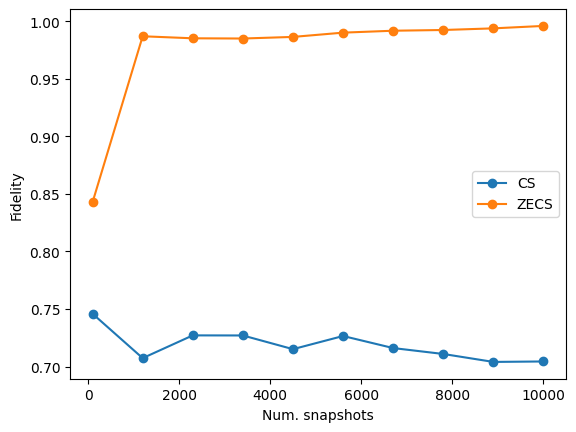

In [88]:
colors = plt.get_cmap('Set2')

fig, ax = plt.subplots()
ax.plot(split_shadows, data[(0,1,2)]["CS"]["F"], marker="o", label="CS")
ax.plot(split_shadows, data[(0,1,2)]["ZECS"]["F"], marker="o", label="ZECS")
ax.set_ylabel("Fidelity")
ax.set_xlabel("Num. snapshots")
ax.legend()



Text(0.5, 1.0, 'Ideal')

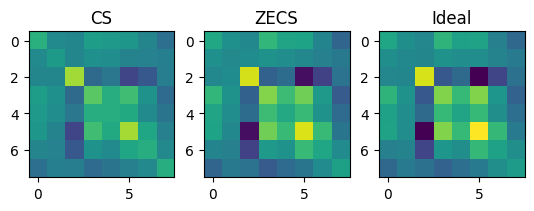

In [94]:
fig, ax = plt.subplots(1,3)
system = (0,1,2)
p_ideal = data["sv_ideal"][system] @ data["sv_ideal"][system].T.conj()
vmin = np.min(p_ideal.real)
vmax = np.max(p_ideal.real)
ax[0].imshow(data[system]["CS"]["rho"].real, vmin=vmin, vmax=vmax)
ax[0].set_title("CS")
ax[1].imshow(data[system]["ZECS"]["rho"].real, vmin=vmin, vmax=vmax)
ax[1].set_title("ZECS")
ax[2].imshow(p_ideal.real, vmin=vmin, vmax=vmax)
ax[2].set_title("Ideal")
